In [2]:
import sys
import os
sys.path.insert(0, './confined-colloids')

import lammps2d as lmp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import HTML, clear_output
import jsonpickle
import scipy.optimize as spo
import scipy.spatial as spa 


import getpass
import pysftp

import re


%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Expression for the induced dipole

In [6]:
import sympy as sm
sm.init_printing()

## Exact Solution

However, the induced dipole of two particles can be solved exactly by solving a system of linear equations. Consider the simplest case where two dipoles are in a plane perpendicular to the magnetic field.

<img src="InducedDipole-TwoDipoles.png", width="500px">

Here we can define:
$\newcommand{\vec}[1]{{\bf #1}}$
$\newcommand{\uvec}[1]{{\bf \hat{e}_{#1}}}$

$$
\vec{B}_{ext}=B_0\uvec{z} \\
\vec{r}_{12} = x\uvec{x} \\
\vec{r}_{21} = -x\uvec{x}
$$


The magnetic dipole moment of superparagnetic particle $1$ with susceptibility $\chi$ and volume $V$ is:

$$\vec{m}_1 = \frac{V\chi\vec{B}}{\mu_{0}}\\
\vec{m}_1 = \frac{V\chi}{\mu_0}\left(\vec{B}_{ext}+\vec{B}_{21}\right)
$$
Conversely for particle $2$:
$$
\vec{m}_2 = \frac{V\chi}{\mu_0}\left(\vec{B}_{ext}+\vec{B}_{12}\right)
$$

where $\vec{B}_{12}$ the field in the center of particle $2$ produced by particle $1$:
$$\vec{B}_{12} = \frac{\mu_0}{4\pi}
\left(
\frac{3\vec{r}_{21}\left(\vec{r}_{21}\cdot\vec{m}_1\right)}{\left|\vec{r}_{21}\right|^5} - 
\frac{\vec{m}_1}{\left|\vec{r}_{21}\right|^3}
\right)
$$
and
$$\vec{B}_{21} = \frac{\mu_0}{4\pi}
\left(
\frac{3\vec{r}_{12}\left(\vec{r}_{12}\cdot\vec{m}_2\right)}{\left|\vec{r}_{12}\right|^5} - 
\frac{\vec{m}_2}{\left|\vec{r}_{12}\right|^3}
\right)
$$

which, substituting the expressions for $\vec{r}_{ij}$ gives:
$$\vec{B}_{12} = \frac{\mu_0}{4\pi x^3}
\left(
3\left(\vec{m}_1\cdot\uvec{x}\right)\uvec{x} - 
\vec{m}_1
\right)
$$
and
$$\vec{B}_{21} = \frac{\mu_0}{4\pi x^3}
\left(
3\left(\vec{m}_2\cdot \uvec{x}\right)\uvec{x}-
\vec{m}_2
\right)
$$

Which we can substitute on the moment expressions to get:

$$
\boxed{
\vec{m}_1 = {V\chi}\left(\frac{\vec{B}_{ext}}{\mu_0}+
\frac{1}{4\pi x^3}
\left(
3\left(\vec{m}_2\cdot \uvec{x}\right)\uvec{x}-
\vec{m}_2
\right)\right)}\\
\boxed{
\vec{m}_2 = {V\chi}\left(\frac{\vec{B}_{ext}}{\mu_0}+
\frac{1}{4\pi x^3}
\left(
3\left(\vec{m}_1\cdot\uvec{x}\right)\uvec{x} - 
\vec{m}_1
\right)\right)
}
$$

Which is what Vilfan uses in his program to correct the moment.

We can further solve this by writing:
$$
\vec{m}_1 - \frac{{V\chi}}{4\pi x^3}
\left(
3\left(\vec{m}_2\cdot \uvec{x}\right)\uvec{x}-
\vec{m}_2
\right)
= \frac{{V\chi}\vec{B}_{ext}}{\mu_0}
$$
$$
\vec{m}_2 - \frac{{V\chi}}{4\pi x^3}
\left(
3\left(\vec{m}_1\cdot\uvec{x}\right)\uvec{x} - 
\vec{m}_1
\right) 
= \frac{{V\chi}\vec{B}_{ext}}{\mu_0} 
$$

First we get the component in the $\uvec{x}$ direction by obaining the dot product of both sides. Here we will write $m^i$ to abbreviate $\vec{m}\cdot\uvec{i}$.

$$
m_1^x - \frac{{V\chi}}{2\pi x^3}
m_2^x
= \frac{{V\chi}\vec{B}_{ext}\cdot\uvec{x}}{\mu_0}\\
m_2^x - \frac{{V\chi}}{2\pi x^3}
m_1^x
= \frac{{V\chi}\vec{B}_{ext}\cdot\uvec{x}}{\mu_0}
$$
Which in matrix form is: 
$$
\left[
\begin{array}{c}
1 & -\frac{{V\chi}}{2\pi x^3} \\
-\frac{{V\chi}}{2\pi x^3} & 1
\end{array}
\right]
\left[
\begin{array}{c}
m_1^x\\
m_2^x
\end{array}
\right] = 
\frac{{V\chi}\vec{B}_{ext}\cdot\uvec{x}}{\mu_0}\left[
\begin{array}{c}
1\\
1
\end{array}
\right] 
$$

However, in this case $\vec{B}_{ext}\cdot\uvec{x} = 0$ and the only solution to the system of equations is the trivial solution $$\left[m_1^x,m_2^x\right] = \left[0,0\right]$$

If $\vec{B}_{ext}\cdot\uvec{x}\neq0$:

In [12]:
Vchi, x, m1x, m2x, Bx, mu0 = sm.symbols("V\chi x m_1^x m_2^x B_x \mu_0")

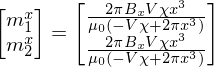

In [14]:
a = -Vchi/2/sm.pi/x**3
b = Vchi*Bx/mu0

A = sm.Matrix([[1, a],[a,1]])
B = sm.Matrix([[b],[b]])
X = sm.Matrix([[m1x],[m2x]])

sm.Eq(X,sm.simplify(sm.Inverse(A)*B))

On the other hand, for the component of the moment in the $\uvec{z}$ direction we obtain:
$$
m_1^z + \frac{{V\chi}}{4\pi x^3}
m_2^z
= \frac{{V\chi}\vec{B}_{ext}\cdot\uvec{z}}{\mu_0}
$$
$$
m_2^z + \frac{{V\chi}}{4\pi x^3}
m_1^z
= \frac{{V\chi}\vec{B}_{ext}\cdot\uvec{z}}{\mu_0} 
$$
Which in matrix form is: 
$$
\left[
\begin{array}{c}
1 & \frac{{V\chi}}{4\pi x^3} \\
\frac{{V\chi}}{4\pi x^3} & 1
\end{array}
\right]
\left[
\begin{array}{c}
m_1^z\\
m_2^z
\end{array}
\right] = 
\frac{{V\chi}\vec{B}_{ext}\cdot\uvec{z}}{\mu_0}\left[
\begin{array}{c}
1\\
1
\end{array}
\right] 
$$

However, in this case, $\vec{B}_{ext}\cdot\uvec{z}=B_0$ and we get:
$$
\boxed{
\left[
\begin{array}{c}
1 & \frac{{V\chi}}{4\pi x^3} \\
\frac{{V\chi}}{4\pi x^3} & 1
\end{array}
\right]
\left[
\begin{array}{c}
m_1^z\\
m_2^z
\end{array}
\right] = 
\frac{{V\chi}B_0}{\mu_0}\left[
\begin{array}{c}
1\\
1
\end{array}
\right]}
$$

In [243]:
Vchi, x, m1z, m2z, B0, mu0 = sm.symbols("V\chi x m_1^z m_2^z B_0 \mu_0")

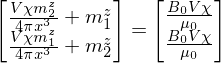

In [253]:
a = Vchi/4/sm.pi/x**3
b = Vchi*B0/mu0

A = sm.Matrix([[1, a],[a,1]])
B = sm.Matrix([[b],[b]])
X = sm.Matrix([[m1z],[m2z]])

sm.Eq(A*X,B)

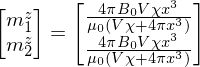

In [261]:
sm.Eq(X,sm.simplify(sm.Inverse(A)*B))

So the resulting dipole moments must be:
$$\vec{m}_1 = \vec{m}_2 = \frac{V\chi B_0}{\mu_0}\frac{1}{\frac{V\chi}{4\pi x^3}+1}\uvec{z}$$

##  An example:

Suppose we have two particles 3 microns appart. 

In [262]:
rho = 1.4*ureg.um
V = 4/3*np.pi*rho**3
chi = 0.4

## The vector that goes from particle one to particle two.
r = np.array([3,0,0])*ureg.um

B_m0 = 2.66e-6 * ureg.C/ureg.us/ureg.um
mu0 = 4e-7*np.pi*ureg.H/ureg.m
(B_m0*mu0).to(ureg.mT)

<Quantity(3342.65458341954, 'millitesla')>

Let's think about these units for a bit later.

### Exact evaluation

For the moment we expect the resulting dipole moment to be:


In [266]:
moment_naive = V*chi*B_m0
moment_naive

<Quantity(1.2229658902537618e-05, 'coulomb * micrometer ** 2 / microsecond')>

In [274]:
moment_corrected = V*chi*B_m0*(1/(1+V*chi/(4*np.pi*(np.linalg.norm(r)*r.units)**3)))
moment_corrected

<Quantity(1.2066155053321254e-05, 'coulomb * micrometer ** 2 / microsecond')>

So The correction is small

### Iterative method

Now we'll iterate N times

In [336]:
N = 10

In [337]:
def correction(m,r):
    rdotm = np.sum(r*m)
    rmag = np.linalg.norm(r)*r.units
    return 1/(4*np.pi)*(3*r*rdotm/rmag**5-m/rmag**3)

In [338]:
m_units = (B_m0*V*chi).units
m0 = [0,0,(B_m0*V*chi).magnitude]*m_units

M = np.empty([N,3,2])*m_units
M[0,:,0] = m0
M[0,:,1] = m0
M[1:,0:3,:] = np.NaN*m_units

In [340]:
for i,mm in enumerate(M):
    if i>0:
        
        M[i,:,0] = M[0,:,0]+V*chi*correction(M[i-1,:,1],r)
        M[i,:,1] = M[0,:,1]+V*chi*correction(M[i-1,:,0],r)

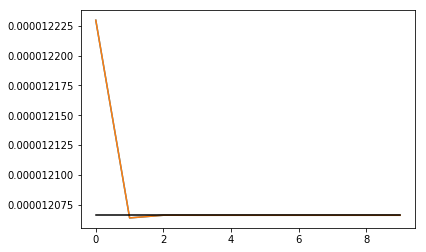

In [345]:
plt.plot(M.magnitude[:,2,:])
plt.plot(np.arange(N),moment_corrected*np.ones(N),'k')

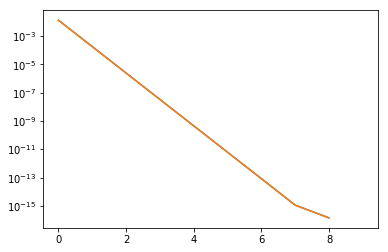

In [353]:
plt.semilogy(abs(M[:,2,:]-moment_corrected)/moment_naive)

### Out of plane colloids:

In [5]:
rho = 1.4*ureg.um
V = 4/3*np.pi*rho**3
chi = 0.4
h = 4*ureg.um

## The vector that goes from particle one to particle two.

B_m0 = 2.66e-6 * ureg.C/ureg.us/ureg.um
mu0 = 4e-7*np.pi*ureg.H/ureg.m
(B_m0*mu0).to(ureg.mT)

def inducedmoment(h):

    r = np.array([np.sqrt(h.magnitude*(4*rho.magnitude-h.magnitude)),0,(h.magnitude-2*rho.magnitude)])*ureg.um

    def correction(m,r):
        rdotm = np.sum(r*m)
        rmag = np.linalg.norm(r)*r.units
        return 1/(4*np.pi)*(3*r*rdotm/rmag**5-m/rmag**3)

    N = 10

    m_units = (B_m0*V*chi).units
    m0 = [0,0,(B_m0*V*chi).magnitude]*m_units

    M = np.empty([N,3,2])*m_units
    M[0,:,0] = m0
    M[0,:,1] = m0
    M[1:,0:3,:] = np.NaN*m_units

    for i,mm in enumerate(M):
        if i>0:

            M[i,:,0] = M[0,:,0]+V*chi*correction(M[i-1,:,1],r)
            M[i,:,1] = M[0,:,1]+V*chi*correction(M[i-1,:,0],r)

    return M.magnitude[-1,:,:]

In [6]:
H = np.linspace(4*rho,2*rho,100)

M = np.array([inducedmoment(h*ureg.um) for h in H])

In [7]:
np.shape(M)

(100, 3, 2)

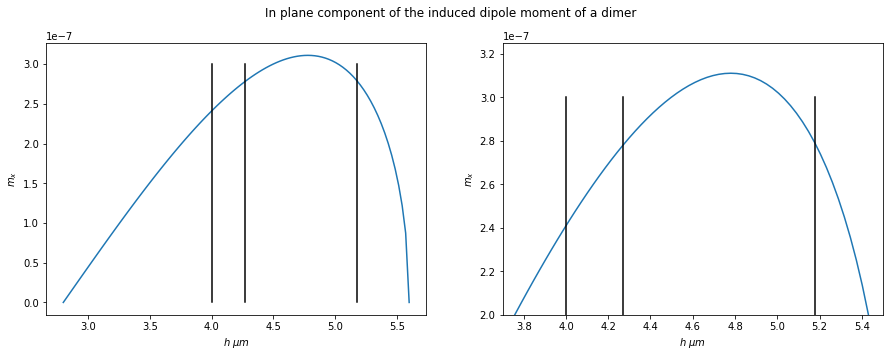

In [21]:
fig, ax = plt.subplots(1,2,figsize=[15,5])
plt.sca(ax[0])
plt.plot(H,M[:,0,0])
plt.xlabel("$h$ $\mu{}m$")
plt.ylabel("$m_x$")

plt.plot([5.18,5.18],[0,3e-7],color='k')
plt.plot([4,4],[0,3e-7],color='k')
plt.plot([4.27,4.27],[0,3e-7],color='k')

plt.sca(ax[1])

plt.plot(H,M[:,0,0])
plt.xlabel("$h$ $\mu{}m$")
plt.ylabel("$m_x$")

plt.plot([5.18,5.18],[0,3e-7],color='k')
plt.plot([4,4],[0,3e-7],color='k')
plt.plot([4.27,4.27],[0,3e-7],color='k')

plt.xlim([3.7,5.5])
plt.ylim([2e-7,3.25e-7])

fig.suptitle("In plane component of the induced dipole moment of a dimer")

(2e-07, 3.25e-07)

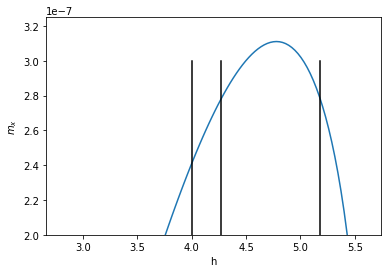

In [14]:
plt.plot(H,M[:,0,0])
plt.xlabel("h")
plt.ylabel("$m_x$")

plt.plot([5.18,5.18],[0,3e-7],color='k')
plt.plot([4,4],[0,3e-7],color='k')
plt.plot([4.27,4.27],[0,3e-7],color='k')

plt.ylim([2e-7,3.25e-7])